# 第2节 二叉树计算欧式和美式期权价格
<br><br/>
* [2.1 简介](#2_1)  
* [2.2 二叉树计算期权价格算法](#2_2)
* [2.3 计算过程 Python 代码实现](#2_3)  
* [2.4 相关说明](#2_4)  
    * [2.4.1 计算例子](#2_4_1)
    * [2.4.2 树形定价收敛情况](#2_4_2)

## <a name="1_1"></a> 2.1 简介
<br></br>
&nbsp; &nbsp; &nbsp; &nbsp; 
考虑期权为股票期权，二叉树是指股票价格在期限内可能的变化路径的图形。

考虑时间段为0至T，对于步数为N的二叉树，在$t=0,\; \Delta t, ...,(N-1)\Delta t$ 的时间节点上股票价格有概率$p$由当前价格$S_t$变为$uS_t$，有概率$(1-p)$变为$dS_t$。其中$\Delta t = \frac{T}{N}$, u和d分别为上升和下降幅度。当二叉树的步数足够多时，股票价格的最后分布将为对数正态分布。  

&nbsp; &nbsp; &nbsp; &nbsp; 
John Hull的《期权、期货及其他衍生产品》中说明了当我们要求没有无风险套利空间，选取$p=\frac{e^{r\Delta t}-d}{u-d}$时，期权在当前节点的价格为期权在分叉后价格期望的贴现后价格。此外我们需要选取的$u$和$d$会让股票价格的波动率与几何布朗运动：
$$\frac{dS}{S} = r dt + \sigma dz$$
相符合。即考虑下列等式，

$$pu+(1-p)d = e^{r\Delta t}, \;\; p(u-1)^2+(1-p)(d-1)^2-[p(u-1)+(1-p)(d-1)]^2 = \sigma^2\Delta t .$$
让$d=1/u$，我们会得到一个重合的树形。这时忽略$\Delta t$的$\frac{3}{2}$阶小量后会有
$$u=e^{\sigma\sqrt{\Delta t}}, \;\; d = e^{-\sigma\sqrt{\Delta t}}.$$  

&nbsp; &nbsp; &nbsp; &nbsp; 
下面左图和右图分别为一步和多步二叉树分叉过程，多步二叉树中每一个节点的分叉过程都是相同的。

<img src="figures/2_2.png" alt="2_2" style="width:460px;height:340px;float:left;margin-top:50px"/>  
<img src="figures/2_1.png" alt="2_1" style="width:500px;height:400px;float:left;"/>  
$\qquad$   <!-- 可以填补图片右侧剩余空间 -->

## <a name="2_1"></a> 2.2 二叉树计算期权价格算法
### 欧式期权价格
1. 根据给定的股票价格的波动率$\sigma$和无风险利率$r$，按照上图中公式计算出$u,\;d，$和$p$，其中$\Delta t$为每一步步长$T/N$。
1. 计算出股票价格在树形末端每个节点的价格，如上右图右侧。
1. 根据期权类型（看涨或看跌），以及期权的执行价格$K$计算出期权在树形末端的价格分布。
1. 用期权价格的递推关系计算出前一层节点上期权价格的期望值。期权价格的递推关系为
    $$ f_{i,j} = e^{-r\Delta t}(pf_{i+1,j+1}+(1-p)f_{i+1,j})\;.$$
    其中$f_{i, j}$为期权在$i\Delta t$时刻，第$j$层（由下往上数，从0开始）的价格。
1. 重复过程4，直到计算出根节点处期权的价格$f_{0,0}$。  

### 美式期权的价格
&nbsp; &nbsp; &nbsp; &nbsp; 
重复欧式期权价格的计算过程1～3，然后在递推上一层期权价格时考虑可以在该节点执行的情况，具体为：
1. 根据给定的股票价格的波动率$\sigma$和无风险利率$r$，按照上图中公式计算出$u,\;d$和$p$。
1. 计算出股票价格在树形末端每个节点的价格。
1. 根据期权类型（看涨或看跌），以及期权的执行价格$K$计算出期权在树形末端的价格分布。
1. 计算出前一层节点上期权价格的期望值。此时需要考虑可以在该节点执行期权，假设期权为看涨期权，则其价格的递推关系为
    $$ f_{i,j} = \max{\left[S_{i, j}-K,\;e^{-r\Delta t}(pf_{i+1,j+1}+(1-p)f_{i+1,j})\right]}\;.$$
    其中$f_{i, j}$为期权在$i\Delta t$时刻，第$j$层的价格,$\;S_{i,j}$为该处的股票价格。
1. 重复过程4，计算出根节点处期权的价格$f_{0,0}$。

## <a name="2_3"></a> 2.3 计算过程 Python 代码实现

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import math

E = math.e

class Binomial_tree_sim:
    def __init__(self, r, sigma, S_0, K, T, steps, option_type="european", call_or_put="call"):
        """ 用输入参数初始化树。
        """
        self.r = r
        self.sigma = sigma
        self.S_0 = S_0
        self.K = K
        self.T = T
        self.steps = steps
        
        self.option_type = option_type
        self.call_or_put = call_or_put
        
        # 计算出树形分叉参数
        self.dt = self.T/self.steps
        self.u = E**(self.sigma*self.dt**0.5)
        self.d = 1/self.u
        self.p = (E**(self.r*self.dt)-self.d)/(self.u-self.d)
        
        # 将会得到的结果
        self.tree = None
        self.option_price = None
        
        # 计算出一个树形
        self.build_tree()
        
    def build_tree(self):
        """ 计算出股票价格在树形上每个节点的价格。
        """
        self.tree = list()
        for lvl in range(self.steps+1):
            row = list()
            for j in range(lvl+1):
                node = dict()
                node["stock_price"] = self.S_0*self.u**(j)*self.d**(lvl-j)
                node["option_price"] = None
                row.append(node)
            self.tree.append(row)
        return
    
    def calculate_option_price(self):
        """ 计算给定类型期权的价格。
        """
        # 简化参数名称。
        r, K, steps = self.r, self.K, self.steps
        dt, p = self.dt, self.p
        
        # 计算出期权在树形末端的价格。
        for node in self.tree[-1]:
            # 如果是看涨期权。
            if self.call_or_put == "call":
                node["option_price"] = max(node["stock_price"]-K, 0)
            # 如果是看跌期权。
            else:
                node["option_price"] = max(K-node["stock_price"], 0)
        
        # 如果是欧式期权。
        if self.option_type == "european":
            # 递推出树形根节点期权的价格。
            for lvl in range(steps-1, -1, -1):
                for j in range(len(self.tree[lvl])):
                    self.tree[lvl][j]["option_price"] = E**(-r*dt)*(p*self.tree[lvl+1][j+1]["option_price"]+\
                                                    (1-p)*self.tree[lvl+1][j]["option_price"])
        
        # 如果是美式期权，过程同欧式期权，计算节点价格时考虑需不需要在该节点执行。
        else:
            for lvl in range(self.steps-1, -1, -1):
                for j in range(len(self.tree[lvl])):
                    self.tree[lvl][j]["option_price"] = E**(-r*dt)*(p*self.tree[lvl+1][j+1]["option_price"]+\
                                                    (1-p)*self.tree[lvl+1][j]["option_price"])
                    # 考虑要不要这时执行。
                    if self.call_or_put == "call":
                        self.tree[lvl][j]["option_price"] = max(self.tree[lvl][j]["option_price"], \
                                                            self.tree[lvl][j]["stock_price"]-K)
                    else:
                        self.tree[lvl][j]["option_price"] = max(self.tree[lvl][j]["option_price"], \
                                                            K-self.tree[lvl][j]["stock_price"])
        
        self.option_price = self.tree[0][0]["option_price"]

        return 

## <a name="2_4"></a> 2.4 相关说明
### <a name="2_4_1"></a> 2.4.1 计算例子
&nbsp; &nbsp; &nbsp; &nbsp; 
考虑一个期限在3年后，执行价格为10的期权。当前股票价格为10，无风险利率为0.05，股票价格波动率为0.2 。使用10步二叉树，可以如下计算出各种期权价格。

In [3]:
tree_obj = Binomial_tree_sim(0.05, 0.2, 10, 10, 3, 10, option_type="european", call_or_put="call")
tree_obj.calculate_option_price()
print("欧式看涨期权价格为： {:0.4f}".format(tree_obj.option_price))

tree_obj = Binomial_tree_sim(0.05, 0.2, 10, 10, 3, 10, option_type="european", call_or_put="put")
tree_obj.calculate_option_price()
print("欧式看跌期权价格为：{:0.4f}".format(tree_obj.option_price))

tree_obj = Binomial_tree_sim(0.05, 0.2, 10, 10, 3, 10, option_type="american", call_or_put="call")
tree_obj.calculate_option_price()
print("美式看涨期权价格为：{:0.4f}".format(tree_obj.option_price))

tree_obj = Binomial_tree_sim(0.05, 0.2, 10, 10, 3, 10, option_type="american", call_or_put="put")
tree_obj.calculate_option_price()
print("美式看跌期权价格为：{:0.4f}".format(tree_obj.option_price))

欧式看涨期权价格为： 2.0585
欧式看跌期权价格为：0.6656
美式看涨期权价格为：2.0585
美式看跌期权价格为：0.8563


### <a name="2_4_2"></a> 2.4.2 树形定价收敛情况  
&nbsp; &nbsp; &nbsp; &nbsp; 
依旧考虑上面参数的欧式看涨期权，我们可以用解析公式计算出期权价格应该为2.0924。然后我们可以调整树形定价步数，将得到的期权价格和解析解数值进行比较。


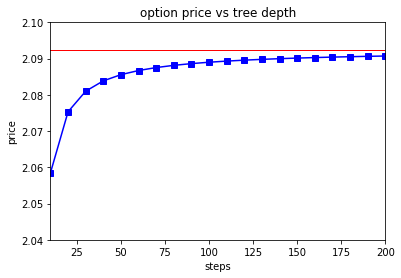

In [34]:
X = np.arange(10, 210, 10)
Y = np.array([])
for steps in X:
    tree_obj = Binomial_tree_sim(0.05, 0.2, 10, 10, 3, steps, option_type="european", call_or_put="call")
    tree_obj.calculate_option_price()
    Y = np.append(Y, [tree_obj.option_price])
    
figure = plt.figure()
ax1 = figure.add_subplot(1, 1, 1)

line1, = ax1.plot(X, Y, '-s', color="blue", linewidth=1.5)
line2, = ax1.plot(X, len(X)*[2.0924], '-', color="red", linewidth=1)

ax1.set_xlabel("steps")
ax1.set_ylabel("price")
ax1.set_title("option price vs tree depth")
ax1.axis((10, 200, 2.04, 2.1))

#figure.savefig("tree_convergence.png", dpi=300)